<a href="https://colab.research.google.com/github/pablex72/vi-phenology-analysis-/blob/main/ML_In_one_FINAL_LSTM_GRU_XGBoost_Random_Forest_SVM_mm33b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM

**Importing Libraries**

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 32)             4352      
                                                                 
 dropout_18 (Dropout)        (None, 1, 32)             0         
                                                                 
 lstm_28 (LSTM)              (None, 1, 16)             3136      
                                                                 
 dropout_19 (Dropout)        (None, 1, 16)             0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                6272      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13793 (53.88 KB)
Trainable params: 13793

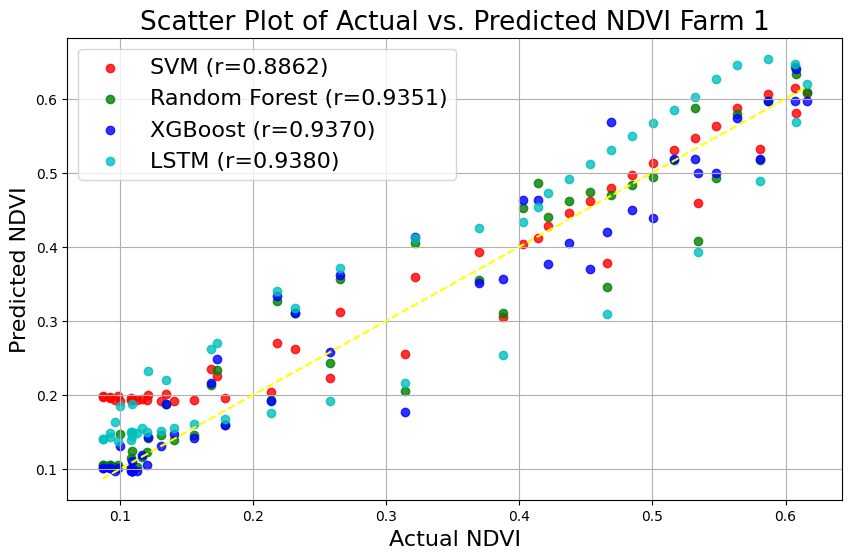

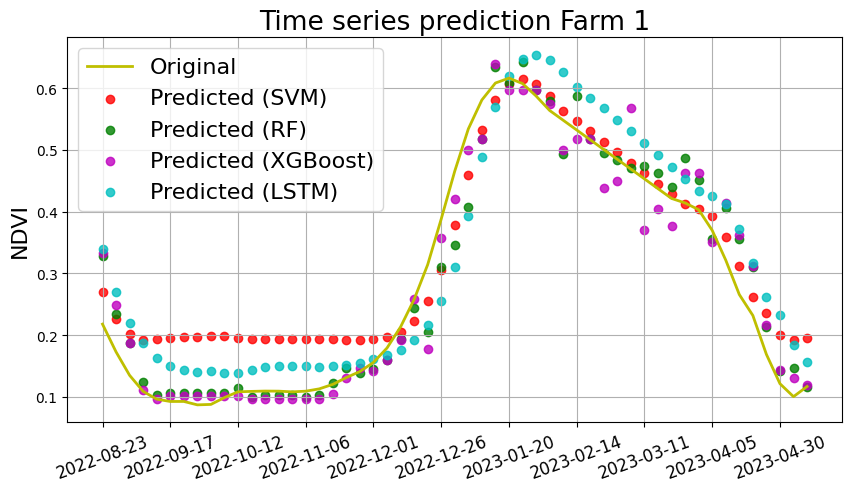

In [56]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv('/content/sg_smoothed_ndvi_farm1.csv')


df_copy = df.copy()

dfDate = df[['Date']]  #index, date (dataframe)

#making date column into index column
df.index = df.pop('Date') #date, ndvi (no index) (dataframe)

testDf = df
df = df.values # ndvi (array)

dfDate=dfDate.values
#dfDate = np.array(dfDate)
dfDate = dfDate.flatten() # date ()
#############################################################################33    FEATURE LENGTH
feature_length = 1
#Splitting
def Create_Features_and_Targets(data, dates, feature_length):
  X = list()
  Y = list()
  datesF = list()
  for i in range(len(data) - feature_length - 1):
    X.append(data[i:(i + feature_length), :])
    Y.append(data[i + feature_length, -1])
  X = np.array(X)
  Y = np.array(Y)
  datesF = np.array(dates[feature_length+1:])
  return datesF, X, Y

dates, X, y = Create_Features_and_Targets(df,dfDate, feature_length)

q_80 = int(len(dates) * .8)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

#LSTM MODEL
# Create the model by importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras.optimizers import Adam

# Define the optimizer with a lower learning rate
adam = Adam(lr=0.001)

# LSTMs are recurrent neural networks (RNNs). In simple terms, LSTMs work by allowing the network to remember
# the context of the model while forgetting the irrelevant information.
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(16, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1, activation='sigmoid'),
])
model.compile(optimizer=adam, loss="mean_squared_error")
model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 12,
    verbose = 0,
)

y_pred = model.predict(X_test)

#######################################################################
# Calculate predicted values
y_pred_lstm = model.predict(X_test)

# Calculate evaluation metrics
r2_lstm = r2_score(y_test, y_pred_lstm)
rmse = mean_squared_error(y_test, y_pred_lstm, squared=False)
mse = mean_squared_error(y_test, y_pred_lstm, squared=True)
mae = mean_absolute_error(y_test, y_pred_lstm)




import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

#df = pd.read_csv('/content/sg_smoothed_ndvi_farm1.csv')
df =  df_copy##
################################################################################
# Build the target, the next NDVI value
df['Target'] = df['NDVI'].shift(-1)
target_df = df[:-1]

# Creating Feature and Target
X = target_df[['NDVI']].values
y = target_df['Target'].values

# Spliting the data into train(80%) and test(20%) parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=False)
# Splitting the dates
train_dates = target_df.Date[:int(len(X)*0.80)]
test_dates =  target_df.Date[int(len(X)*0.80):]

X_train.shape, X_test.shape, y_train.shape, y_test.shape
################################################################################
# Create an SVM regressor
regressor = SVR(kernel='rbf', C=1.0, epsilon=0.1) #0.7760--0.9433
regressor.fit(X_train, y_train)
y_pred_svm = regressor.predict(X_test)
# Calculate evaluation metrics
r2_svm = r2_score(y_test, y_pred_svm)
rmse = mean_squared_error(y_test, y_pred_svm, squared=False)
mse = mean_squared_error(y_test, y_pred_svm, squared=True)
mae = mean_absolute_error(y_test, y_pred_svm)
################################################################################
regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mse_rf = mean_squared_error(y_test, y_pred_rf, squared=True)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
###############   xgboost ##########################################################################################

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate evaluation metrics for XGBoost
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=True)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)



# Create a scatter plot to visualize the correlation between actual and predicted values for all models
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, label=f"SVM (r={r2_svm:.4f})", alpha=0.8, color='r')
plt.scatter(y_test, y_pred_rf, label=f"Random Forest (r={r2_rf:.4f})", alpha=0.8, color='g')
plt.scatter(y_test, y_pred_xgb, label=f"XGBoost (r={r2_xgb:.4f})", alpha=0.8, color='b')
plt.scatter(y_test, y_pred_lstm, label=f"LSTM (r={r2_lstm:.4f})", alpha=0.8, color='c')
#plt.scatter(y_test, y_pred_gru, label=f"GRU (r={r2_gru:.4f})", alpha=0.8, color='m')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='yellow', linestyle='--')
plt.xlabel("Actual NDVI",fontsize = 16)
plt.ylabel("Predicted NDVI",fontsize = 16)
plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
plt.legend(prop={"size": 16})
plt.grid(True)
plt.show()





# Assuming you have y_test, test_dates, and y_pred_rf (Random Forest predictions), y_pred_svm (SVR predictions), y_pred_gru (GRU predictions), and y_pred_xgb (XGBoost predictions), and y_pred_lstm (LSTM predictions)

# Plot Testing Data with Original and Predicted values using scatter
fig, ax = plt.subplots(figsize=(10, 5))

# Plot original values (y_test)
ax.plot(y_test, linewidth=2, label='Original', color='y')

# Scatter plot for SVR predictions (y_pred_svm)
ax.scatter(range(len(y_pred_svm)), y_pred_svm, label='Predicted (SVM)', color='r', marker='o', alpha=0.8)
# Scatter plot for Random Forest predictions (y_pred_rf)
ax.scatter(range(len(y_pred_rf)), y_pred_rf, label='Predicted (RF)', color='g', marker='o', alpha=0.8)
# Scatter plot for GRU predictions (y_pred_gru)
#ax.scatter(range(len(y_pred_gru)), y_pred_gru, label='Predicted (GRU)', color='b', marker='o', alpha=0.8)
# Scatter plot for XGBoost predictions (y_pred_xgb)
ax.scatter(range(len(y_pred_xgb)), y_pred_xgb, label='Predicted (XGBoost)', color='m', marker='o', alpha=0.8)
# Scatter plot for LSTM predictions (y_pred_lstm)
ax.scatter(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted (LSTM)', color='c', marker='o', alpha=0.8)

ax.set_xticks(range(0, len(test_dates.values), 5))
ax.set_xticklabels(test_dates.values[::5], rotation=20,fontsize = 12)

ax.set_title('Time series prediction Farm 1',fontsize = 19)
ax.set_ylabel('NDVI',fontsize = 16)
ax.legend(prop={"size": 16},loc="upper left")
ax.grid(True)
plt.show()

######
# plt.xlabel("Actual NDVI",fontsize = 16)
# plt.ylabel("Predicted NDVI",fontsize = 16)
# plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
# plt.legend(prop={"size": 16})





#svm

In [57]:
df

,Date,NDVI,Target
0,2019-10-08,0.211927,0.168153
1,2019-10-13,0.168153,0.132877
2,2019-10-18,0.132877,0.107515
3,2019-10-23,0.107515,0.093483
4,2019-10-28,0.093483,0.099110
...,...,...,...
259,2023-04-25,0.231774,0.168774
260,2023-04-30,0.168774,0.121294
261,2023-05-05,0.121294,0.100296
262,2023-05-10,0.100296,0.116737


#EVALUATION

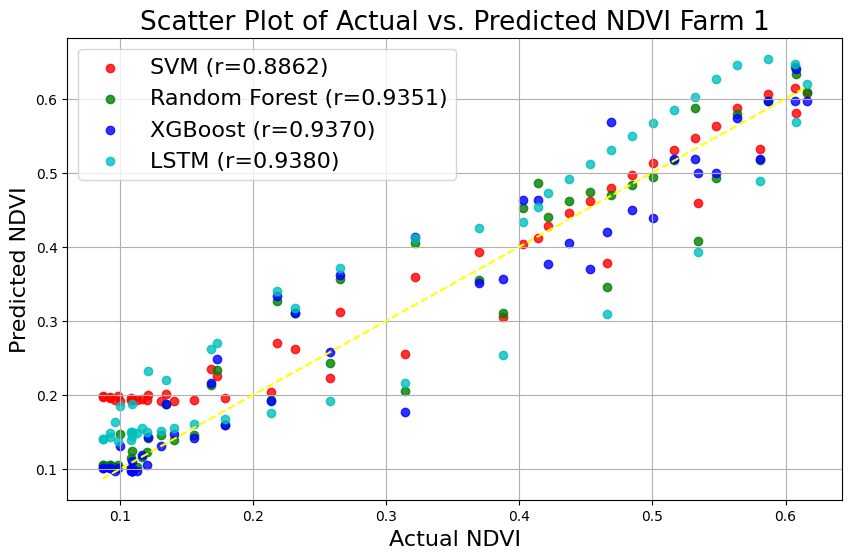

In [58]:
# Create a scatter plot to visualize the correlation between actual and predicted values for all models
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svm, label=f"SVM (r={r2_svm:.4f})", alpha=0.8, color='r')
plt.scatter(y_test, y_pred_rf, label=f"Random Forest (r={r2_rf:.4f})", alpha=0.8, color='g')
plt.scatter(y_test, y_pred_xgb, label=f"XGBoost (r={r2_xgb:.4f})", alpha=0.8, color='b')
plt.scatter(y_test, y_pred_lstm, label=f"LSTM (r={r2_lstm:.4f})", alpha=0.8, color='c')
#plt.scatter(y_test, y_pred_gru, label=f"GRU (r={r2_gru:.4f})", alpha=0.8, color='m')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='yellow', linestyle='--')
plt.xlabel("Actual NDVI",fontsize = 16)
plt.ylabel("Predicted NDVI",fontsize = 16)
plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
plt.legend(prop={"size": 16})
plt.grid(True)
plt.show()


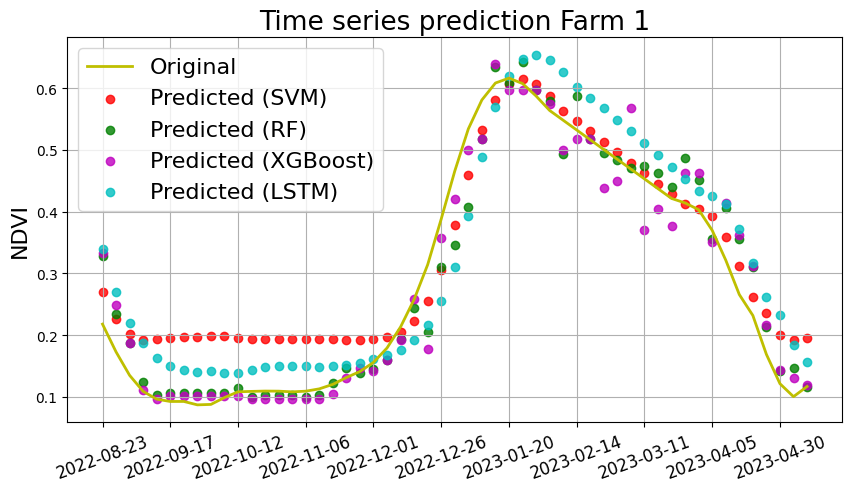

In [59]:
# Assuming you have y_test, test_dates, and y_pred_rf (Random Forest predictions), y_pred_svm (SVR predictions), y_pred_gru (GRU predictions), and y_pred_xgb (XGBoost predictions), and y_pred_lstm (LSTM predictions)

# Plot Testing Data with Original and Predicted values using scatter
fig, ax = plt.subplots(figsize=(10, 5))

# Plot original values (y_test)
ax.plot(y_test, linewidth=2, label='Original', color='y')

# Scatter plot for SVR predictions (y_pred_svm)
ax.scatter(range(len(y_pred_svm)), y_pred_svm, label='Predicted (SVM)', color='r', marker='o', alpha=0.8)
# Scatter plot for Random Forest predictions (y_pred_rf)
ax.scatter(range(len(y_pred_rf)), y_pred_rf, label='Predicted (RF)', color='g', marker='o', alpha=0.8)
# Scatter plot for GRU predictions (y_pred_gru)
#ax.scatter(range(len(y_pred_gru)), y_pred_gru, label='Predicted (GRU)', color='b', marker='o', alpha=0.8)
# Scatter plot for XGBoost predictions (y_pred_xgb)
ax.scatter(range(len(y_pred_xgb)), y_pred_xgb, label='Predicted (XGBoost)', color='m', marker='o', alpha=0.8)
# Scatter plot for LSTM predictions (y_pred_lstm)
ax.scatter(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted (LSTM)', color='c', marker='o', alpha=0.8)

ax.set_xticks(range(0, len(test_dates.values), 5))
ax.set_xticklabels(test_dates.values[::5], rotation=20,fontsize = 12)

ax.set_title('Time series prediction Farm 1',fontsize = 19)
ax.set_ylabel('NDVI',fontsize = 16)
ax.legend(prop={"size": 16},loc="upper left")
ax.grid(True)
plt.show()

######
# plt.xlabel("Actual NDVI",fontsize = 16)
# plt.ylabel("Predicted NDVI",fontsize = 16)
# plt.title("Scatter Plot of Actual vs. Predicted NDVI Farm 1",fontsize = 19)
# plt.legend(prop={"size": 16})
